## **IMPORTING THE REQUIRED LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# **DATASET SETUP & PREPROCESSING**

In [ ]:
df = pd.read_csv("/content/spotify.csv")
print("Dataset Loaded Successfully ✅")
print("Shape of dataset:", df.shape)

Dataset Loaded Successfully ✅
Shape of dataset: (32833, 23)


In [ ]:
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Missing Values ---")
print(df.isnull().sum())

#Handle missing values
#Drop missing rows
df.dropna(inplace=True)
print("\nAfter handling missing values:", df.shape)

# Remove irrelevant columns (if exist)
irrelevant_cols = ['track_id', 'url', 'artist_name']  # adjust based on your CSV
df = df.drop(columns=[col for col in irrelevant_cols if col in df.columns], errors='ignore')

# Encode categorical columns
label_cols = ['genre', 'playlist_name']
encoder = LabelEncoder()

for col in label_cols:
    if col in df.columns:
        df[col] = encoder.fit_transform(df[col])
        print(f"Encoded column: {col}")

#  Scale numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("\n✅ Preprocessing Completed Successfully!")
print("Scaled dataset shape:", df_scaled.shape)

# Save processed dataset
df_scaled.to_csv("spotify_cleaned.csv", index=False)
print("Cleaned dataset saved as spotify_cleaned.csv")


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-nul

# **EXPLORATORY DATA ANALYSIS**

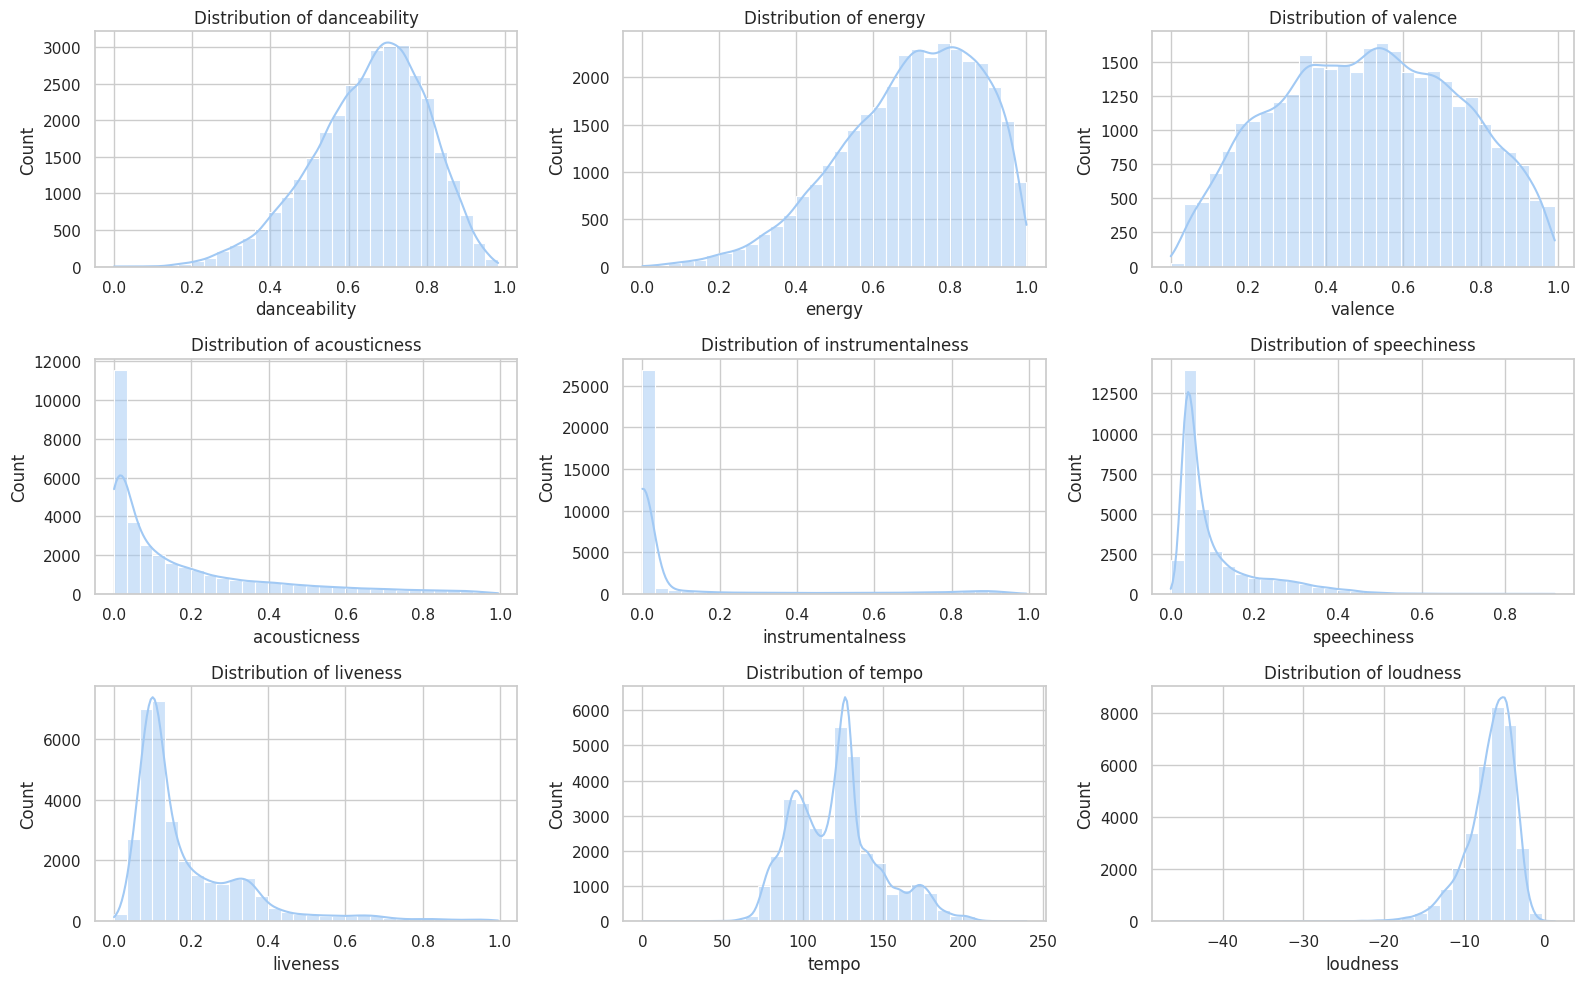

In [ ]:
# Set general plot style
sns.set(style="whitegrid", palette="pastel")

# Distribution plots for key numerical features
num_features = ['danceability', 'energy', 'valence', 'acousticness',
                'instrumentalness', 'speechiness', 'liveness', 'tempo', 'loudness']


plt.figure(figsize=(16, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


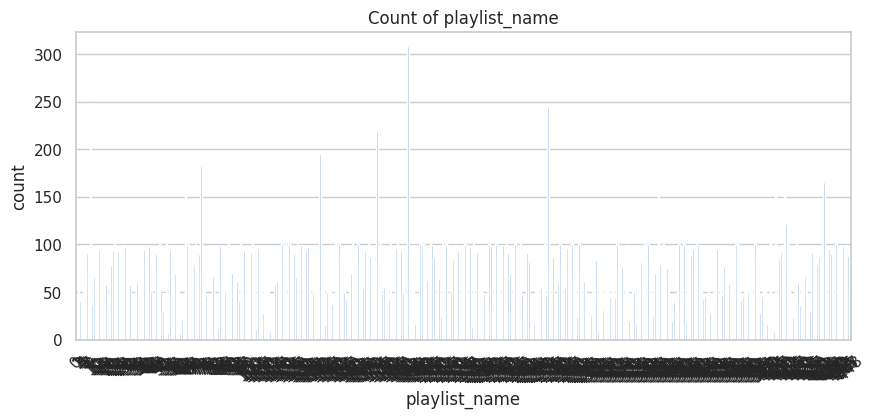

In [ ]:
#Count plots for categorical columns (Genre & Playlist)
cat_features = ['genre', 'playlist_name']
for col in cat_features:
    if col in df.columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(x=col, data=df)
        plt.title(f"Count of {col}")
        plt.xticks(rotation=45)
        plt.show()


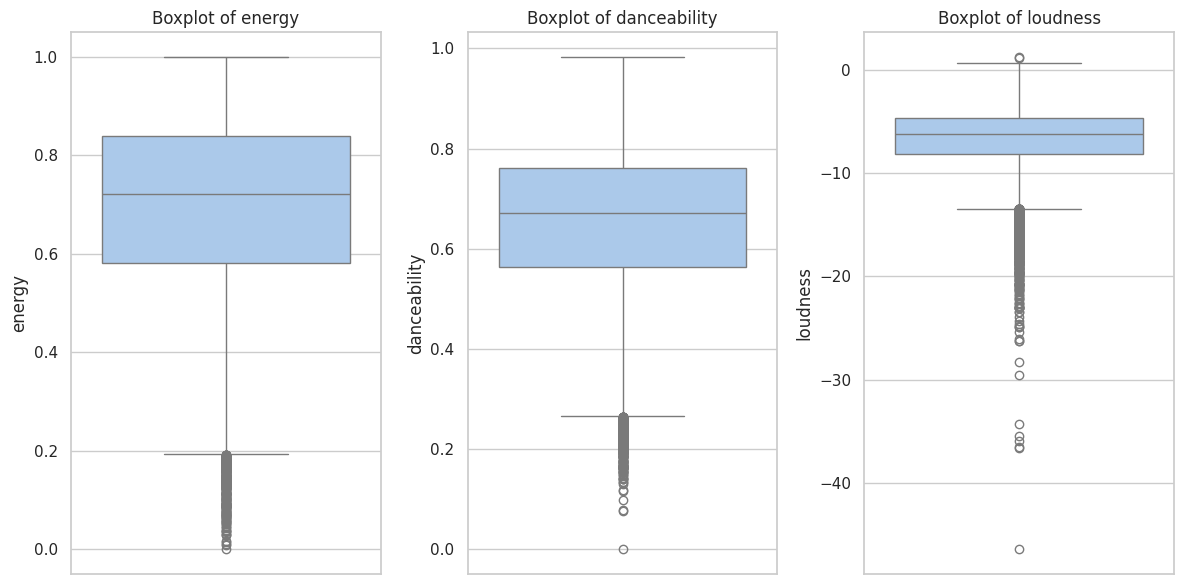

In [ ]:
# Box plots to detect outliers
box_features = ['energy', 'danceability', 'loudness']
plt.figure(figsize=(12, 6))
for i, col in enumerate(box_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=col, data=df)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


# **Feature Correlation Matrix & Selection**

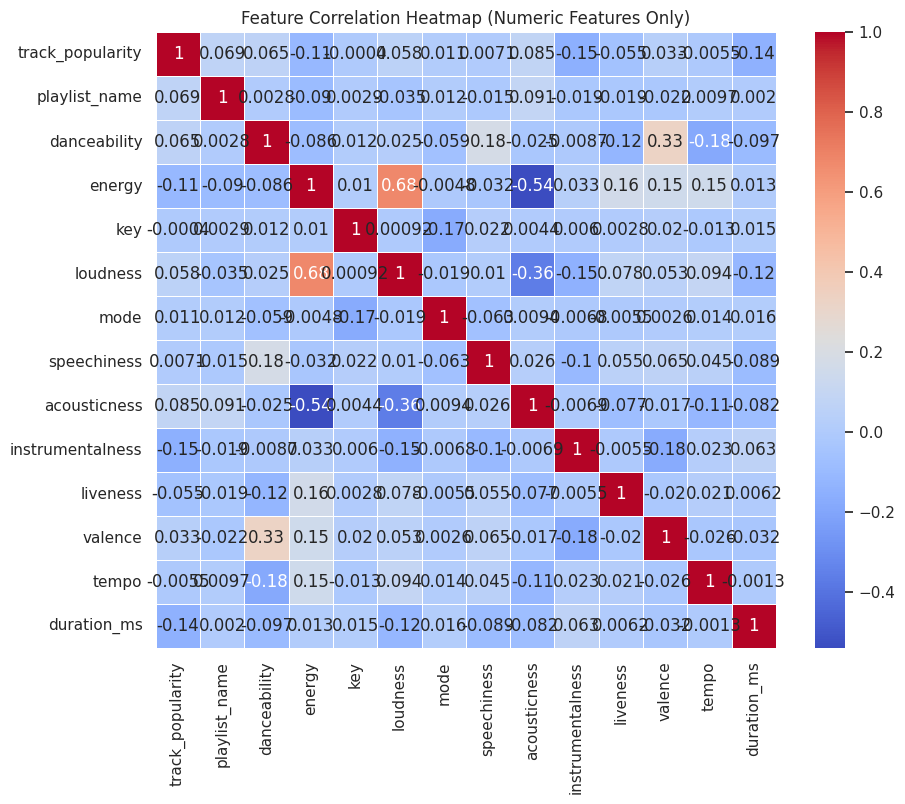

In [ ]:
#Correlation heatmap

plt.figure(figsize=(10, 8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix safely
corr_matrix = numeric_df.corr()

# Draw heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.show()

In [ ]:
# Feature Selection
# Remove redundant features if they’re too correlated
# Example logic:
redundant_features = ['energy', 'loudness']  # example; depends on your correlation results
numeric_selected = numeric_df.drop(columns=[col for col in redundant_features if col in numeric_df.columns], errors='ignore')

print("\n Selected Features for Clustering:")
print(list(numeric_selected.columns))

#Save feature-selected dataset
numeric_selected.to_csv("spotify_features_selected.csv", index=False)
print("\nSaved as spotify_features_selected.csv")


 Selected Features for Clustering:
['track_popularity', 'playlist_name', 'danceability', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

Saved as spotify_features_selected.csv


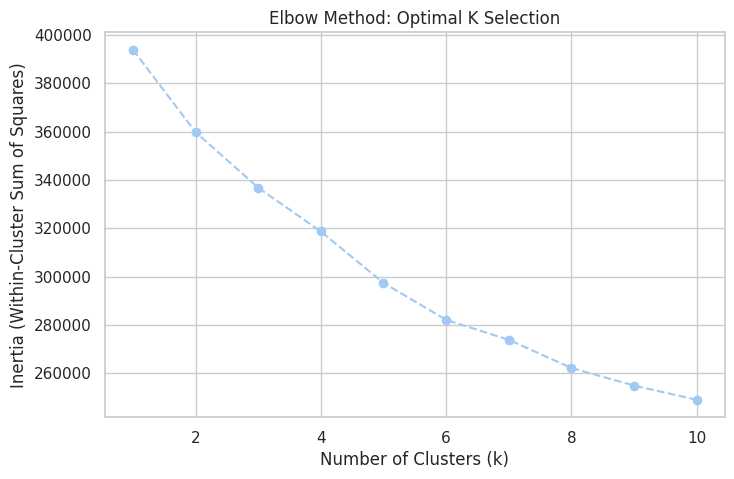

In [ ]:

# Optional: scale again (in case scaling changed)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_selected)

# Use Elbow Method to find optimal number of clusters (k)
inertia_values = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method: Optimal K Selection')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [ ]:

# Choose optimal k (based on elbow — usually around 3–5)
optimal_k = 4  # adjust after checking elbow curve

# Apply K-Means with chosen k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
# Use numeric_selected for clustering
numeric_selected['cluster'] = kmeans_final.fit_predict(scaled_data)

# Save clustered dataset (using the dataframe with original columns)
df['cluster'] = numeric_selected['cluster']
df.to_csv("spotify_clustered.csv", index=False)
print(f"\n K-Means Clustering Completed with k = {optimal_k}")
print(f"Clustered dataset saved as spotify_clustered.csv")

# Display cluster summary
print("\nCluster Distribution:")
print(df['cluster'].value_counts())

# Basic cluster feature means
print("\nCluster Feature Averages:")
# Calculate means using numeric_selected
print(numeric_selected.groupby('cluster').mean().round(2))


✅ K-Means Clustering Completed with k = 4
Clustered dataset saved as spotify_clustered.csv

Cluster Distribution:
cluster
3    11155
0     9857
1     7745
2     4071
Name: count, dtype: int64

Cluster Feature Averages:
         track_popularity  playlist_name  danceability   key  mode  \
cluster                                                              
0                   45.46         219.82          0.71  6.37  0.00   
1                   30.70         211.64          0.53  5.21  0.62   
2                   46.19         255.88          0.60  5.32  0.63   
3                   46.68         222.28          0.71  4.63  1.00   

         speechiness  acousticness  instrumentalness  liveness  valence  \
cluster                                                                   
0               0.13          0.14              0.03      0.18     0.58   
1               0.07          0.06              0.23      0.24     0.33   
2               0.09          0.64              0.12      0

## **PCA & Cluster Visualization**

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


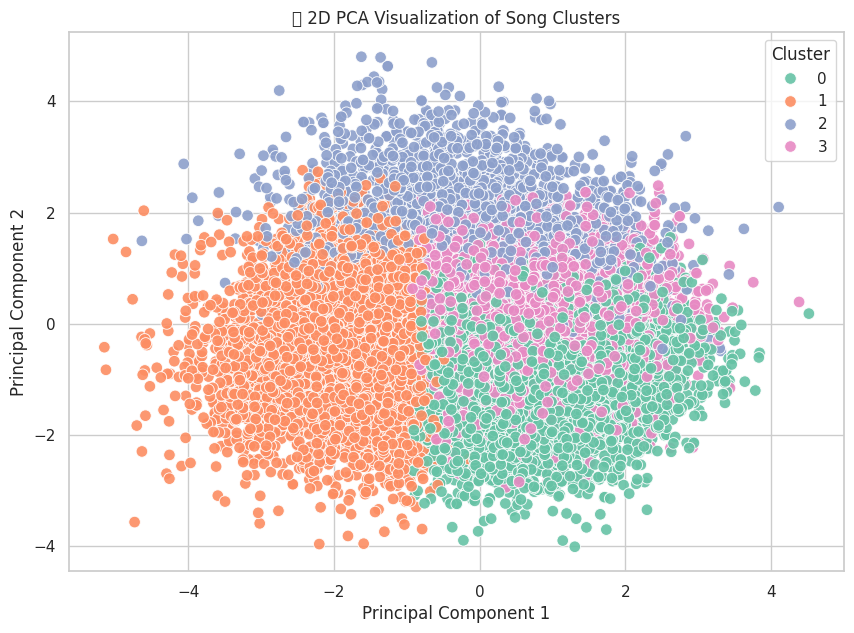

In [ ]:
# Apply PCA (2D)
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(scaled_data)
df['PCA1'] = pca_2d_result[:, 0]
df['PCA2'] = pca_2d_result[:, 1]

# 2D Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='cluster',
    data=df, palette='Set2', s=70, alpha=0.9
)
plt.title("2D PCA Visualization of Song Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


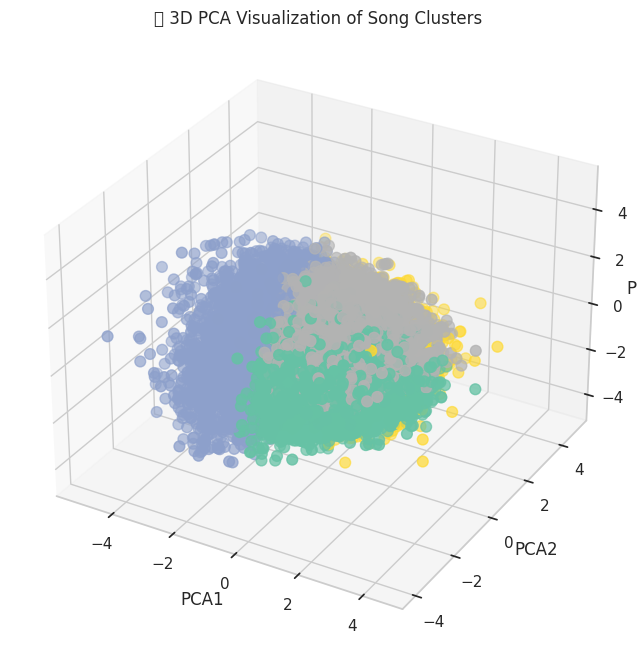

In [ ]:
# Apply PCA (3D)
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(scaled_data)

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    pca_3d_result[:, 0],
    pca_3d_result[:, 1],
    pca_3d_result[:, 2],
    c=df['cluster'], cmap='Set2', s=60
)
ax.set_title("3D PCA Visualization of Song Clusters")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


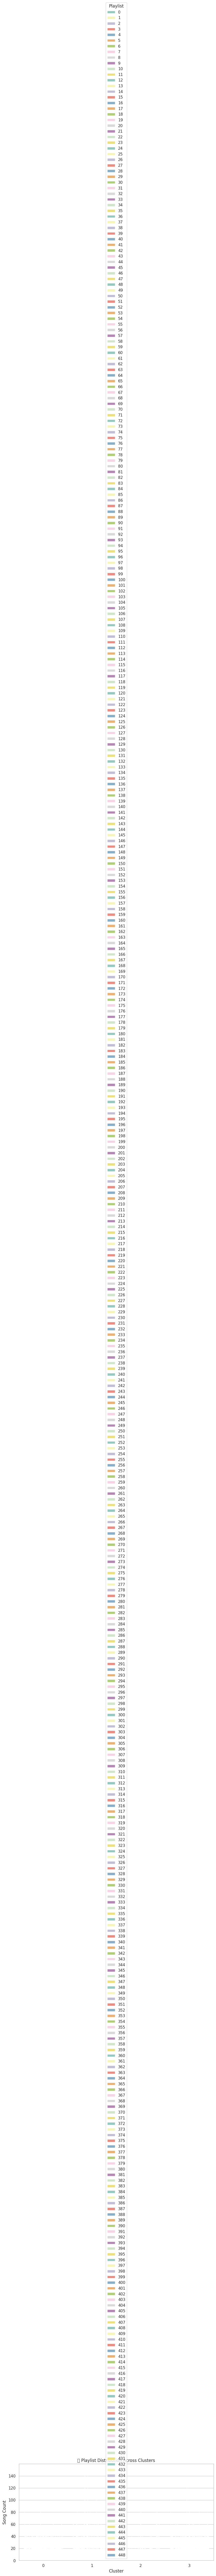

In [ ]:
# Genre distribution
if 'genre' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='cluster', hue='genre', data=df, palette='Set2')
    plt.title("Genre Distribution Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Song Count")
    plt.legend(title='Genre')
    plt.show()

# Playlist distribution
if 'playlist_name' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='cluster', hue='playlist_name', data=df, palette='Set3')
    plt.title("Playlist Distribution Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Song Count")
    plt.legend(title='Playlist')
    plt.show()

# **Simple Cluster-Based Recommendation (Fast & Easy)**

In [ ]:
import random

#Function to recommend songs
def recommend_songs(song_name, n_recommendations=5):
    # Check if the song exists in dataset
    if song_name not in df['track_name'].values:
        print("Song not found in the dataset.")
        return []

    # Get the cluster of the chosen song
    song_cluster = df.loc[df['track_name'] == song_name, 'cluster'].values[0]

    # Filter songs from the same cluster (excluding the chosen one)
    similar_songs = df[df['cluster'] == song_cluster]
    similar_songs = similar_songs[similar_songs['track_name'] != song_name]

    # Randomly sample N similar songs
    recommendations = similar_songs.sample(n=min(n_recommendations, len(similar_songs)))

    print(f"\n Because you liked '{song_name}', you might also enjoy:")
    for idx, row in recommendations.iterrows():
        print(f"   > {row['track_name']}  ({row.get('artist_name', 'Unknown Artist')})")

    return recommendations

#Try the recommender
recommend_songs("Shape of You")  # replace with any song from your dataset



 Because you liked 'Shape of You', you might also enjoy:
   > Never Gonna Give You Up  (Unknown Artist)
   > Bandit (with YoungBoy Never Broke Again)  (Unknown Artist)
   > Fave Thing  (Unknown Artist)
   > Donde Hubo Fuego  (Unknown Artist)
   > Mary Jane  (Unknown Artist)


,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
26735,Never Gonna Give You Up,The Black Keys,50,7qE6RXYyz5kj5Tll7mJU0v,Brothers,2010-05-18,329,5EMARioe9z9eKOeWIAC2JW,r&b,neo soul,...,-6.190,0,0.0328,0.3240,0.000281,0.0713,0.437,75.805,218987,0
21372,Bandit (with YoungBoy Never Broke Again),Juice WRLD,92,3t6Z2qoBVCS4NHNI25XECH,Bandit (with YoungBoy Never Broke Again),2019-10-04,254,5WNUX6jisX0NRlVDTm6RDd,r&b,urban contemporary,...,-5.884,0,0.3430,0.0687,0.000000,0.1320,0.425,180.051,189323,0
5579,Fave Thing,Funky Notes,56,0ecADXvGhKIWjKDwX37Aox,Fave Thing,2019-11-01,200,37i9dQZF1DX0SM0LYsmbMT,rap,hip hop,...,-13.170,0,0.2740,0.2120,0.000528,0.1390,0.233,169.471,184000,0
19624,Donde Hubo Fuego,Daddy Yankee,53,7txBx0XCrl5IhJuTNgNV4w,12 Discipulos,2005,316,0si5tw70PIgPkY1Eva6V8f,latin,reggaeton,...,-5.428,0,0.0784,0.1860,0.000000,0.2180,0.868,93.358,205977,0
7135,Mary Jane,Scarface,30,0yEbGVnKvWj4B85rzExJmF,The Untouchable,1997,21,2NMW1nwQYSVlXd26uLenX6,rap,southern hip hop,...,-9.370,0,0.1790,0.0146,0.000006,0.0429,0.370,79.821,281067,0


# **Advanced Recommendation (Cluster + Feature Similarity)**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

features = df.select_dtypes(include=['number']).drop(columns=['cluster'], errors='ignore')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Create function for similarity-based recommendations
def smart_recommend(song_name, n_recommendations=5):
    if song_name not in df['track_name'].values:
        print("Song not found in dataset.")
        return []

    # Find the song index and its cluster
    song_index = df[df['track_name'] == song_name].index[0]
    song_cluster = df.loc[song_index, 'cluster']

    # Filter songs from the same cluster
    same_cluster_indices = df[df['cluster'] == song_cluster].index

    # Compute similarities within that cluster
    cluster_similarities = [
        (i, similarity_matrix[song_index][i])
        for i in same_cluster_indices if i != song_index
    ]

    # Sort by similarity (descending)
    cluster_similarities.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_indices = [i for i, sim in cluster_similarities[:n_recommendations]]
    recommendations = df.loc[top_indices]

    print(f"\n Smart Recommendations for '{song_name}':")
    for _, row in recommendations.iterrows():
        print(f"   > {row['track_name']}  ({row.get('artist_name', 'Unknown Artist')})")

    return recommendations

#Try it out
smart_recommend("Shape of You")  # change this song name as per your dataset



 Smart Recommendations for 'Shape of You':
   > Shape of You  (Unknown Artist)
   > Shape of You  (Unknown Artist)
   > Shape of You  (Unknown Artist)
   > El Efecto  (Unknown Artist)
   > Love Riddim  (Unknown Artist)


,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
23894,Shape of You,Ed Sheeran,86,3T4tUhGYeRNVUGevb0wThu,÷ (Deluxe),2017-03-03,370,7ENISpOJhocpMJVcGb0qcT,r&b,hip pop,...,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,233713,0
23862,Shape of You,Ed Sheeran,75,7oJa8bPFKVbq4c7NswXHw8,Shape of You,2017-01-06,370,7ENISpOJhocpMJVcGb0qcT,r&b,hip pop,...,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,233713,0
2838,Shape of You,Ed Sheeran,86,3T4tUhGYeRNVUGevb0wThu,÷ (Deluxe),2017-03-03,125,4frhr6RQM2fMOm2mpvOVo6,pop,electropop,...,-3.183,0,0.0802,0.581,0.000000,0.0931,0.931,95.977,233713,0
19021,El Efecto,Rauw Alejandro,78,6C8ObcezFoorqPgY2J320r,El Efecto,2019-03-15,278,37i9dQZF1DWUlCmB8llCTB,latin,reggaeton,...,-4.635,0,0.1590,0.406,0.000000,0.0801,0.893,84.041,217143,0
25389,Love Riddim,Rotimi,62,0FtaeZat9rX3tooDlGtzWM,Love Riddim,2019-04-18,249,1eqVgsNjaX6mxDPoefhocT,r&b,neo soul,...,-5.616,0,0.0351,0.311,0.000007,0.0964,0.795,107.074,219482,0
